<a href="https://colab.research.google.com/github/vfantacone/jafamo/blob/master/SDNTraffic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset from the ISCX Database**: https://www.unb.ca/cic/datasets/vpn.html

# UNB ISCX Network Traffic Dataset content

**Web Browsing**: Firefox and Chrome

**Email**: SMPTS, POP3S and IMAPS

**Chat**: ICQ, AIM, Skype, Facebook and Hangouts

**Streaming**: Vimeo and Youtube

**File Transfer**: Skype, FTPS and SFTP using Filezilla and an external service

**VoIP**: Facebook, Skype and Hangouts voice calls (1h duration)

**P2P**: uTorrent and Transmission (Bittorrent)






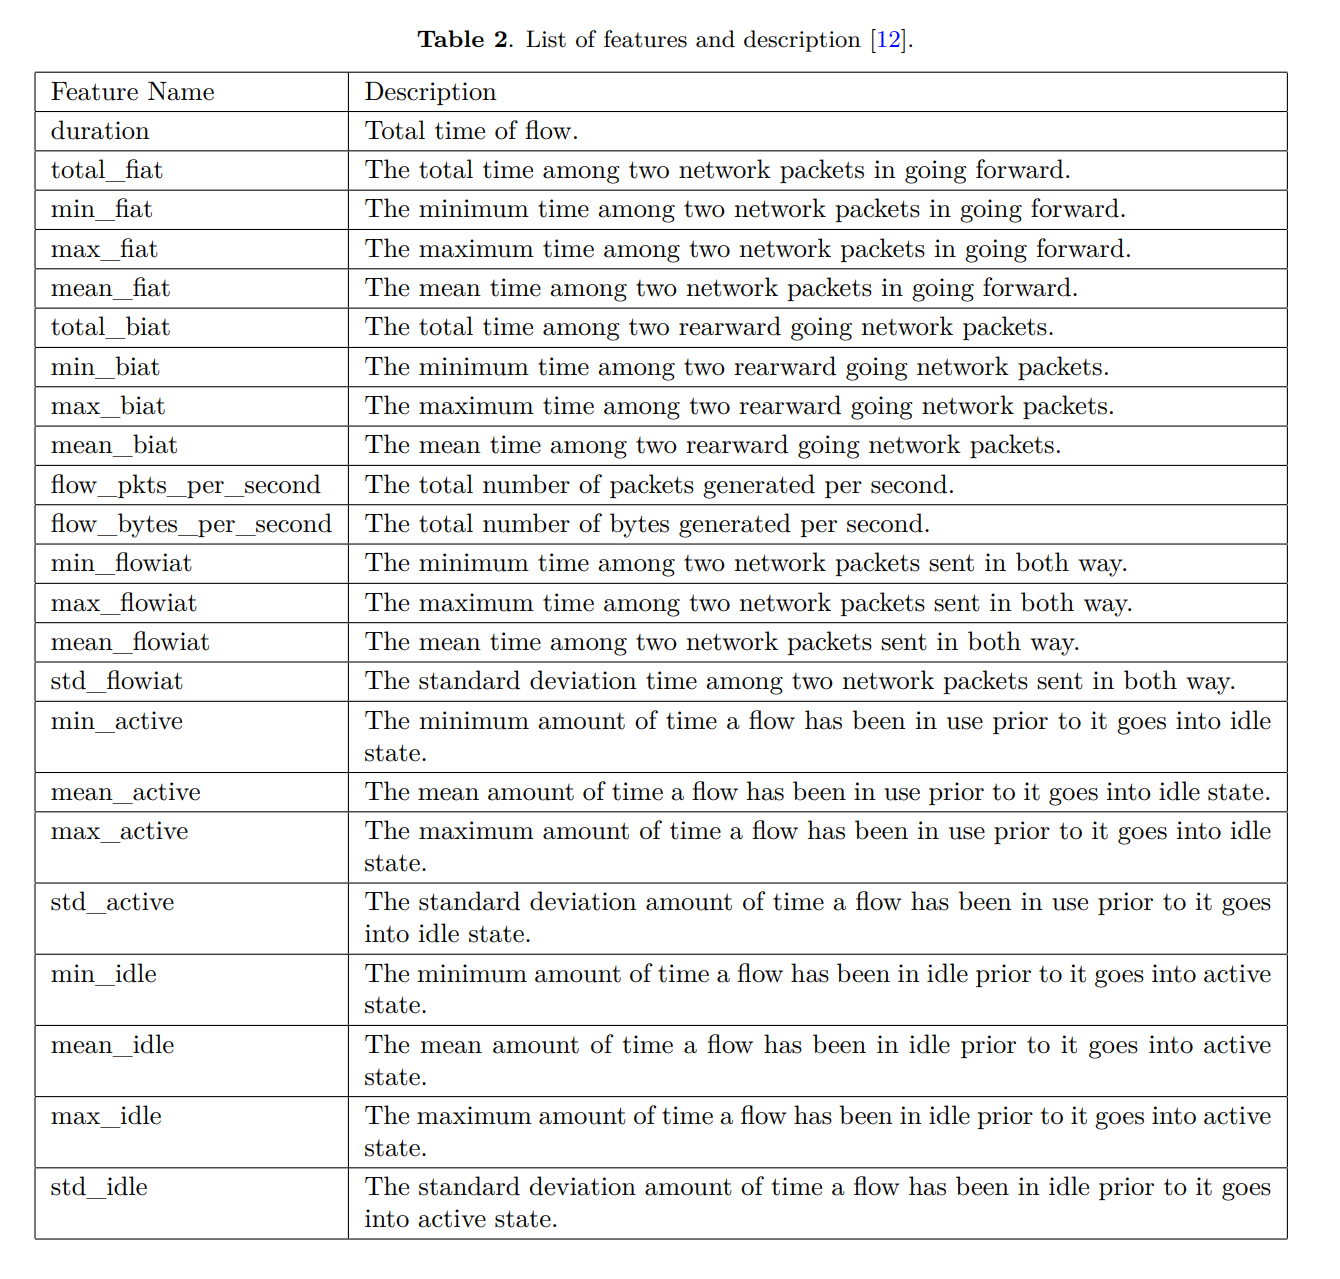

### **IMPORTING OF THE NECESSARY LIBRIRIES**

In [2]:
import pickle
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn. metrics import accuracy_score
from keras.utils.vis_utils import plot_model

### **LOADING OF THE DATASET**

In [3]:
# Read the Dataset in .arff Format
from scipy.io import arff

data = arff.loadarff('/content/drive/MyDrive/Neural-Network-for-NM/Datasets/ISCX/ISCX/Scenario A2/TimeBasedFeatures-Dataset-120s-VPN.arff')
df = pd.DataFrame(data[0])

#CONVERT dataframe to csv file
# df.to_csv("/content/drive/MyDrive/Neural-Network-for-NM/Datasets/ISCX/ISCX/Scenario B/TimeBasedFeatures-Dates-120s-AllinOne.csv")

df.head()
df.shape

(5631, 24)

In [ ]:
df.sample(30) # Show 30 random records of the dataset

## **WHICH KIND OF TRAFFIC HAS BEEN TRACED?**

In [ ]:
array_1D = df['class1'].unique()  #Show list of possible values of feature 'class1'
print('\n'.join('{}: {}'.format(*val) for val in enumerate(array_1D)))

### **QUICK STATISTIC SUMMARY OF THE DATASET**

In [ ]:
df.describe() #shows a quick statistic summary of the dataset

### **DATA TYPE INFORMATION SUMMARY. find and replace missing value in a column with NA**

In [11]:
# Convert the class1 data type from "object" to "string"
df['class1'] = df['class1'].astype('str')

In [ ]:
df.info()

In [13]:
df.dropna(inplace=True) # find and replace missing value in a column with NA
df.isna().sum()  # returns the number of missing values in each column

duration              0
total_fiat            0
total_biat            0
min_fiat              0
min_biat              0
max_fiat              0
max_biat              0
mean_fiat             0
mean_biat             0
flowPktsPerSecond     0
flowBytesPerSecond    0
min_flowiat           0
max_flowiat           0
mean_flowiat          0
std_flowiat           0
min_active            0
mean_active           0
max_active            0
std_active            0
min_idle              0
mean_idle             0
max_idle              0
std_idle              0
class1                0
dtype: int64

### **Creating dummy OUTPUTS for the class1 column to make our algorithm more efficient**

In [14]:
df.class1.unique()

array(["b'VPN-BROWSING'", "b'VPN-CHAT'", "b'VPN-FT'", "b'VPN-MAIL'",
       "b'VPN-P2P'", "b'VPN-STREAMING'", "b'VPN-VOIP'"], dtype=object)

In [15]:
df = pd.get_dummies(df) # creating dummy variables for the class1 column to make our algorithm more efficient
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,mean_idle,max_idle,std_idle,class1_b'VPN-BROWSING',class1_b'VPN-CHAT',class1_b'VPN-FT',class1_b'VPN-MAIL',class1_b'VPN-P2P',class1_b'VPN-STREAMING',class1_b'VPN-VOIP'
0,119364082.0,119364082.0,119338343.0,9.0,17.0,58714597.0,58776480.0,32702.488219,20131.299426,80.258649,...,5.850000e+07,58714597.0,2.624102e+05,1,0,0,0,0,0,0
1,93952224.0,93736153.0,93738835.0,6.0,7.0,45211965.0,45220727.0,37645.041365,28319.889728,61.754791,...,4.500000e+07,45006375.0,6.181527e+03,1,0,0,0,0,0,0
2,73934090.0,73802530.0,73804692.0,3.0,14.0,27749148.0,27746116.0,55117.647498,25189.314676,57.767668,...,7.350662e+06,27617038.0,1.010000e+07,1,0,0,0,0,0,0
3,42933658.0,42803851.0,42933658.0,0.0,0.0,5957694.0,5958561.0,31706.556296,16055.967838,93.772583,...,3.334210e+06,5828435.0,1.382747e+06,1,0,0,0,0,0,0
4,270207.0,203681.0,244006.0,15.0,10.0,27147.0,66572.0,593.822157,363.104167,3763.781101,...,0.000000e+00,-1.0,0.000000e+00,1,0,0,0,0,0,0


In [16]:
df.shape

(5631, 30)

### **Drop of columns/OUTPUTS that are considered non relevant**

In [ ]:
# df.drop(['min_fiat', 'min_biat', 'class1', 'flowBytesPerSecond', 'std_flowiat', 'flowPktsPerSecond', 'mean_idle', 'min_idle', 'max_idle'], axis=1, inplace=True)  
# df.drop(['min_fiat', 'min_biat', 'mean_idle', 'min_idle', 'max_idle', 'min_active', 'mean_active', 'std_active','std_idle','max_active', 'max_biat', 'mean_biat', 'max_fiat', 'total_fiat', 'total_biat', 'duration', 'min_flowiat','mean_fiat','max_flowiat', 'mean_flowiat', 'std_flowiat'], axis=1, inplace=True)   #The class1 column has been replaced by the added dummy class columns
#df.drop(['class1'], axis=1, inplace=True)


df.drop(["class1_b'VPN-STREAMING'", "class1_b'VPN-FT'", "class1_b'VPN-MAIL'", "class1_b'VPN-CHAT'", "class1_b'VPN-P2P'", "class1_b'VPN-BROWSING'"], axis=1, inplace=True)
df.head()

### **Next, we will apply a MinMax Scaler to standardize our dataset and make all values in range (0,1)**

In [19]:
scaler = MinMaxScaler() # This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

df_std= scaler.fit_transform(df)
df_std

df_std.shape

(5631, 24)

In [20]:
df_std

array([[1.98475389e-01, 6.21833436e-01, 1.98505150e-01, ...,
        9.78397823e-02, 1.56196521e-03, 0.00000000e+00],
       [1.56221234e-01, 4.88323398e-01, 1.55923411e-01, ...,
        7.49969204e-02, 3.67948060e-05, 0.00000000e+00],
       [1.22935619e-01, 3.84478145e-01, 1.22765334e-01, ...,
        4.60199878e-02, 6.01190476e-02, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

### **CONVERT THE ARRAY BACK IN A PANDAS DATAFRAME**

In [23]:
new_df = pd.DataFrame(df_std, columns=df.columns)  # CONVERT THE ARRAY BACK IN A PANDAS DATAFRAME
new_df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1_b'VPN-VOIP'
0,0.198475,0.621833,0.198505,8.339315e-08,1.500005e-07,0.306897,0.097943,0.000273,0.000168,0.000040,...,0.009973,0.097732,0.099334,0.100701,0.007514,0.097221,0.097500,0.097840,0.001562,0.0
1,0.156221,0.488323,0.155923,5.837520e-08,6.666688e-08,0.236320,0.075354,0.000314,0.000236,0.000031,...,0.009853,0.075177,0.078037,0.080685,0.013941,0.074982,0.075000,0.074997,0.000037,0.0
2,0.122936,0.384478,0.122765,3.335726e-08,1.250004e-07,0.145043,0.046235,0.000459,0.000210,0.000029,...,0.006111,0.002491,0.015237,0.046431,0.055162,0.001860,0.012251,0.046020,0.060119,0.0
3,0.071389,0.222989,0.071415,8.339315e-09,8.333360e-09,0.031140,0.009929,0.000264,0.000134,0.000047,...,0.001915,0.002711,0.008761,0.018881,0.018653,0.002181,0.005557,0.009712,0.008231,0.0
4,0.000449,0.001061,0.000406,1.334290e-07,9.166696e-08,0.000142,0.000111,0.000005,0.000003,0.001882,...,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


### **SPLITTING OF THE DATASET INTO: Input X AND Output y**

In [26]:
# spliting our dataset into input X and output y variables

X = new_df.iloc[:,0:23].astype(float)

y = new_df.iloc[:,23:24]

X

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle
0,0.198475,0.621833,0.198505,8.339315e-08,1.500005e-07,0.306897,0.097943,0.000273,0.000168,4.012932e-05,...,0.000208,0.009973,0.097732,0.099334,0.100701,0.007514,0.097221,0.097500,0.097840,0.001562
1,0.156221,0.488323,0.155923,5.837520e-08,6.666688e-08,0.236320,0.075354,0.000314,0.000236,3.087740e-05,...,0.000270,0.009853,0.075177,0.078037,0.080685,0.013941,0.074982,0.075000,0.074997,0.000037
2,0.122936,0.384478,0.122765,3.335726e-08,1.250004e-07,0.145043,0.046235,0.000459,0.000210,2.888383e-05,...,0.000289,0.006111,0.002491,0.015237,0.046431,0.055162,0.001860,0.012251,0.046020,0.060119
3,0.071389,0.222989,0.071415,8.339315e-09,8.333360e-09,0.031140,0.009929,0.000264,0.000134,4.688629e-05,...,0.000178,0.001915,0.002711,0.008761,0.018881,0.018653,0.002181,0.005557,0.009712,0.008231
4,0.000449,0.001061,0.000406,1.334290e-07,9.166696e-08,0.000142,0.000111,0.000005,0.000003,1.881891e-03,...,0.000004,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5626,0.037960,0.118930,0.000000,2.920353e-03,0.000000e+00,0.052282,0.000000,0.031707,0.000000,1.533121e-07,...,0.063415,0.045465,0.003327,0.009496,0.016632,0.020715,0.003335,0.009178,0.016668,0.021612
5627,0.000001,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.117318e-03,...,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5628,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5629,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
y

,class1_b'VPN-VOIP'
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
5626,1.0
5627,1.0
5628,1.0
5629,1.0


### **METHOD FOR EVALUATING THE INPUT FEATURES HAVING STRONGER RELATIONSHIP WITH THE SELECTED OUTPUT**

**Univariate Selection** ----
select those features that have the strongest relationship with the output variable

https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=2)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

          Specs       Score
1    total_fiat  164.649324
2    total_biat   53.439354
0      duration   47.597133
5      max_fiat   11.670075
14  std_flowiat    5.380965
17   max_active    4.468450
21     max_idle    4.415694
12  max_flowiat    4.330964
22     std_idle    3.941064
18   std_active    3.815536


**Feature Importance** ------ Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.
Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


[0.0615341  0.06764447 0.08598732 0.06654896 0.08466339 0.04603996
 0.06795954 0.03522766 0.0400599  0.01861819 0.01698408 0.03952693
 0.04243635 0.02081594 0.03726374 0.02129903 0.0306419  0.03874606
 0.02465133 0.0317738  0.0359202  0.05663734 0.02901982]


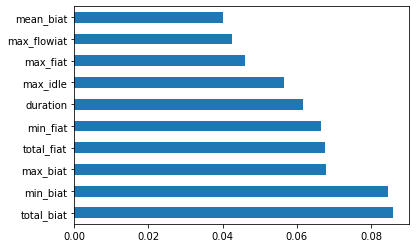

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [31]:
model.feature_importances_

array([0.0615341 , 0.06764447, 0.08598732, 0.06654896, 0.08466339,
       0.04603996, 0.06795954, 0.03522766, 0.0400599 , 0.01861819,
       0.01698408, 0.03952693, 0.04243635, 0.02081594, 0.03726374,
       0.02129903, 0.0306419 , 0.03874606, 0.02465133, 0.0317738 ,
       0.0359202 , 0.05663734, 0.02901982])

### **Correlation Matrix with Heatmap**

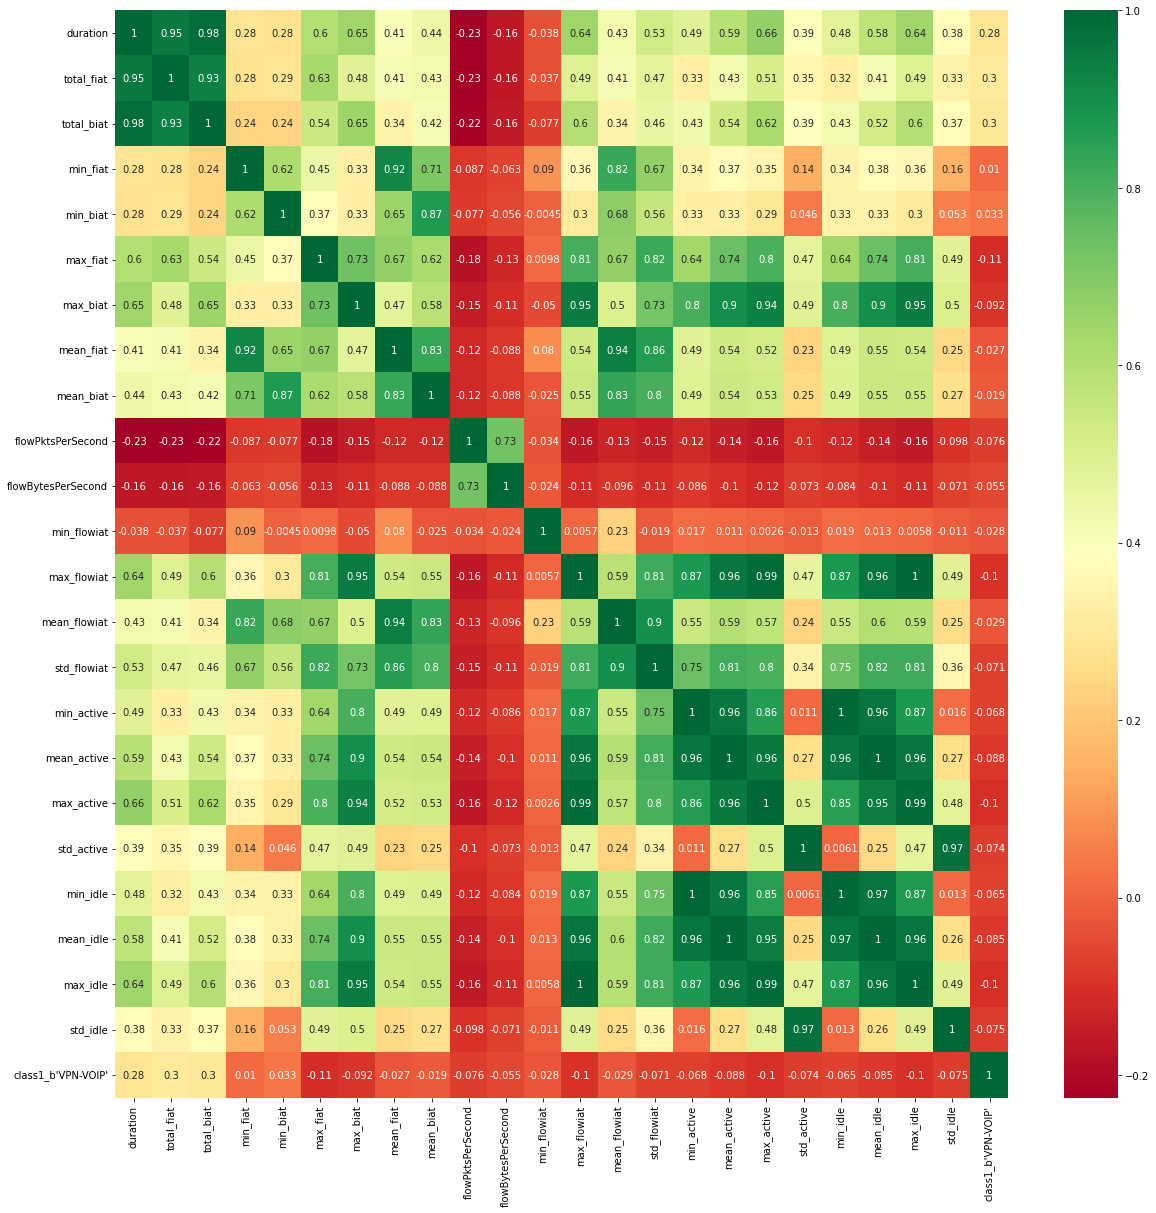

In [32]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = new_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(new_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### **MODEL COMPLEXITY SELECTION: Principal Component Analysis, PCA, of the features**
In some studies PCA is used to determine
the hidden layers number: https://peerj.com/articles/cs-724/

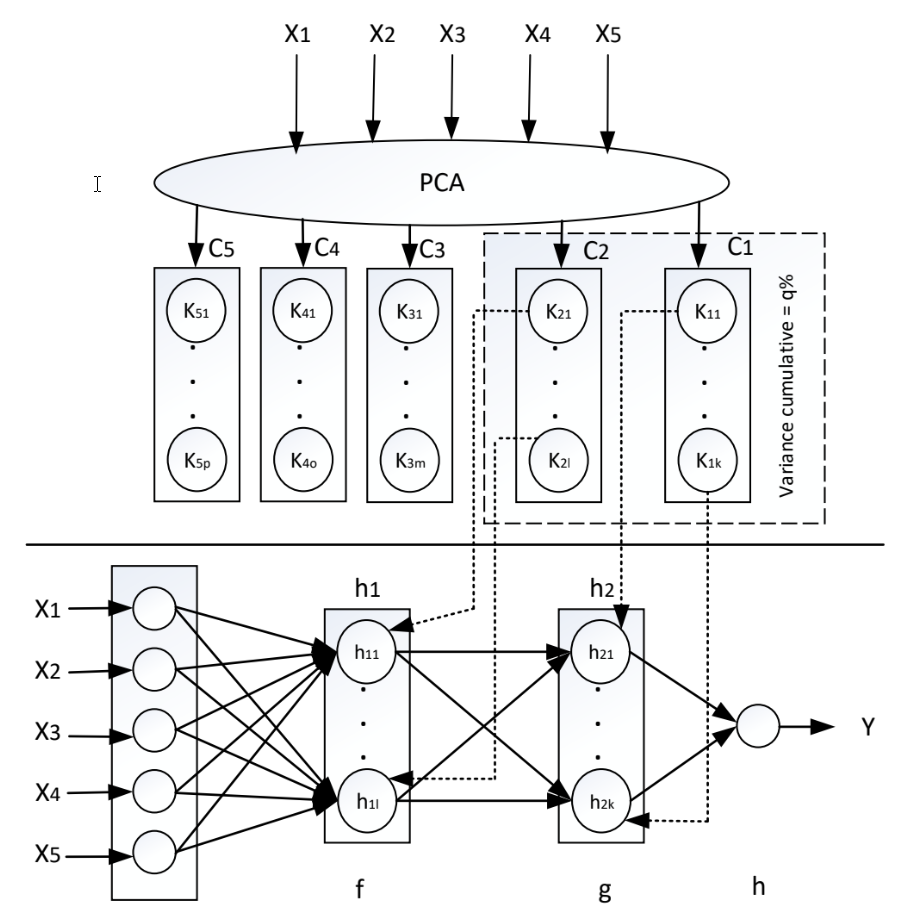

In [33]:
my_list = list(X) # convert X in a list
print(my_list)

['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


In [34]:
# Principal Component Analysis, PCA, of the features

import matplotlib.pyplot as plt
import seaborn as sns

# load decomposition to do PCA analysis with sklearn
from sklearn import decomposition

NumPCA_Components = 23 # we consider 23 Components = to the number of features/inputs of the model

pca = decomposition.PCA(n_components=NumPCA_Components)
pc = pca.fit_transform(X)

In [35]:
pc_df = pd.DataFrame(data = pc) # put the PC in a dataframe
pc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.440960,-0.251499,0.180291,0.017200,0.051181,0.013559,-0.077688,-0.153711,0.006022,0.010275,...,-0.040493,0.006430,-0.017385,0.009232,0.001759,-0.005679,-0.005099,0.000548,-0.000051,0.000089
1,0.290140,-0.191973,0.137950,0.013594,0.036863,0.008946,-0.056712,-0.116663,0.001279,0.009632,...,-0.032648,0.000983,-0.013391,0.007305,-0.000806,-0.004324,-0.003923,0.001467,-0.000143,0.000004
2,0.148247,-0.170436,0.048338,-0.022603,-0.054605,0.012862,0.010785,-0.052385,-0.003321,0.013229,...,-0.008298,-0.001375,0.011504,-0.004707,0.004451,-0.001483,-0.001025,0.000468,0.001356,0.000043
3,-0.044587,-0.099159,-0.016062,0.000707,0.000275,-0.005758,0.007661,-0.007218,-0.009190,0.005686,...,-0.004205,-0.004586,0.001533,-0.000419,0.000428,0.001175,-0.000958,-0.000806,0.000359,-0.000081
4,-0.256534,0.028279,-0.006059,0.004670,-0.003552,-0.006342,-0.001803,0.000173,-0.002997,-0.000249,...,0.000339,0.000162,-0.000005,-0.000456,-0.000040,-0.000017,-0.000190,-0.000054,0.000010,-0.000098


In [36]:
pc_histo = pca.explained_variance_ratio_ # Percentage of variance explained by each of the selected components
pc_histo.shape
pc_histo

array([6.26712920e-01, 1.97031906e-01, 6.35118736e-02, 2.98223395e-02,
       2.32952815e-02, 1.94119446e-02, 1.76209233e-02, 7.94843274e-03,
       6.62122683e-03, 3.91625243e-03, 1.04329885e-03, 1.01579086e-03,
       6.60799098e-04, 5.09058143e-04, 3.61617161e-04, 2.14962356e-04,
       1.70387244e-04, 4.90697826e-05, 3.80349111e-05, 3.43369617e-05,
       8.33497827e-06, 9.01196689e-07, 3.07909862e-07])

In [37]:
# riempie una lista con numeri in un range prestabilito. 

search_list = []
search_list.extend(range(1, 101)) # [1,2,3,4,5,6,...,98,99,100]
print(search_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


[0.6267129203499473, 0.19703190566001014, 0.06351187359789415, 0.02982233951309506, 0.023295281521225317, 0.019411944636033494, 0.017620923262143175, 0.007948432744610087, 0.00662122683080977, 0.0039162524305629545, 0.001043298851739903, 0.0010157908586321321, 0.0006607990979792859, 0.0005090581433245834, 0.0003616171614913911, 0.0002149623560059196, 0.00017038724428110626, 4.906978260214253e-05, 3.803491113691343e-05, 3.433696165390468e-05, 8.334978270519085e-06, 9.011966891640008e-07, 3.0790986157809144e-07]


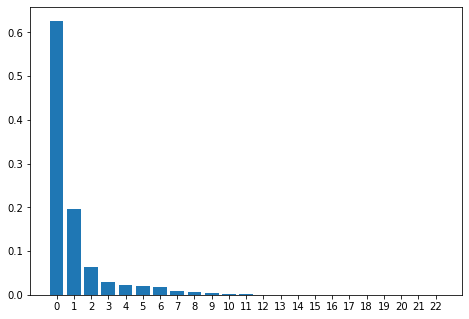

In [38]:
# drawing the histogram

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']#, '23', '24', '25', '26', '27', '28']

variance = pc_histo.tolist()
print(variance)
ax.bar(langs, variance)
plt.show()

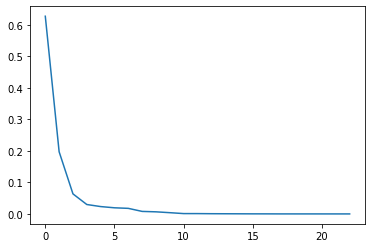

In [39]:
plt.plot(variance)

### **get the name of the top 10 measurements (features) that contribute most to pc0**

In [40]:
## get the name of the top 10 measurements (features) that contribute
## most to pc0
## first, get the loading scores
loading_scores = pd.Series(pca.components_[0], index=my_list)
## now sort the loading scores based on their magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
 
# get the names of the top 10 genes
top_10_features = sorted_loading_scores[0:10].index.values
 
## print the gene names and their scores (and +/- sign)
print(loading_scores[top_10_features])

total_fiat      0.729544
max_fiat        0.275330
duration        0.241224
std_flowiat     0.232616
total_biat      0.228174
mean_fiat       0.220861
mean_biat       0.202765
mean_flowiat    0.187451
min_fiat        0.158365
min_biat        0.128716
dtype: float64


### **Spliting our dataset into a training set (80%) and a test set (20%)**

In [41]:
# spliting our dataset into a training set (80%) and a test set (20%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)  #  RANDOM_STATE: is used for initializing the internal random number generator, which will decide the splitting of data into train and test indices in your case

**K-Nearest Classification**



In [42]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
# cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [43]:
ac

0.9893522626441881

--------- Decision Tree Prediction ----------


In [44]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [45]:
predictions = model.predict(X_test)
score = accuracy_score(y_test, predictions)
score

0.9920141969831411

### **------------------- Defining the Neural Network Model-----------------------**

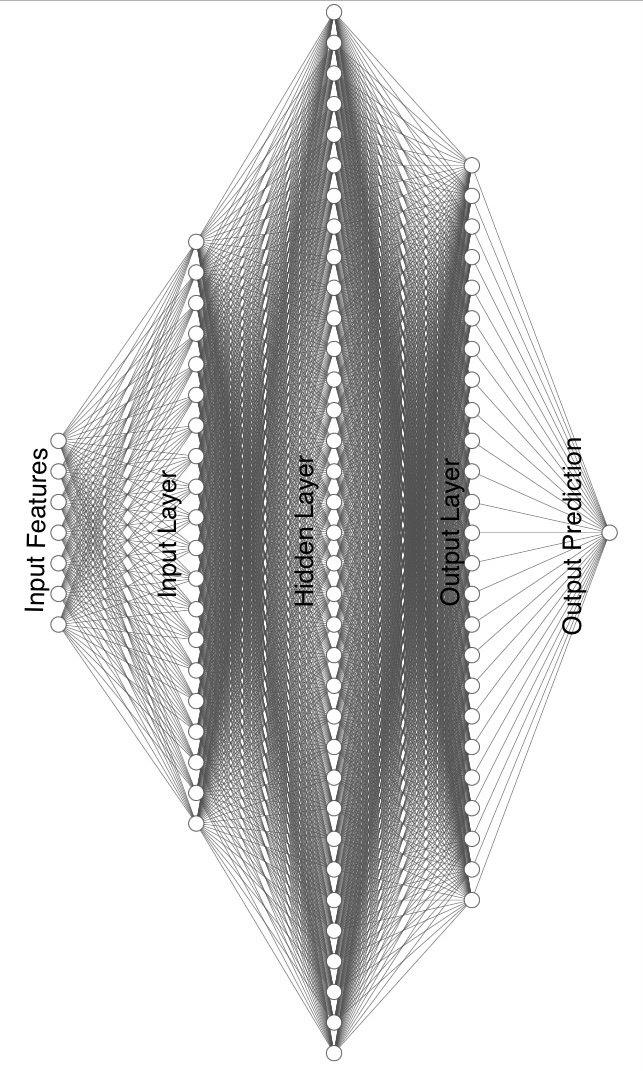

In [49]:
# defining our Neural Network model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(23,), activation='relu')) # INPUT LAYER
model.add(Dense(512, activation='relu')) # HIDDEN LAYER 1
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu')) # HIDDEN LAYER 2
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu')) # OUTPUT LAYER
model.add(Dense(1, activation='sigmoid')) # OUTPUT

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1536      
                                                                 
 dense_5 (Dense)             (None, 512)               33280     
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                      

In [52]:
# This callback will stop the training when there is no improvement in the validation loss for "patience" consecutive epochs.  
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=50,
    restore_best_weights=True
)

In [53]:
# We used binary crosentropy to calculate the loss at each epoch of training and Adam optimizer

model.compile(loss='binary_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [54]:
# we train our model

model.fit(X_train, 
          y_train, 
          epochs=200,
          batch_size=250, 
          verbose=1, 
          validation_split=0.2,
          callbacks=[es])

Epoch 1/200
15/15 [==============================] - 2s 37ms/step - loss: 0.7848 - accuracy: 0.6298 - val_loss: 0.6336 - val_accuracy: 0.8901
Epoch 2/200
15/15 [==============================] - 0s 17ms/step - loss: 0.6035 - accuracy: 0.7552 - val_loss: 0.5498 - val_accuracy: 0.9612
Epoch 3/200
15/15 [==============================] - 0s 17ms/step - loss: 0.5088 - accuracy: 0.8387 - val_loss: 0.4904 - val_accuracy: 0.9811
Epoch 4/200
15/15 [==============================] - 0s 17ms/step - loss: 0.3958 - accuracy: 0.8923 - val_loss: 0.4229 - val_accuracy: 0.9811
Epoch 5/200
15/15 [==============================] - 0s 17ms/step - loss: 0.3279 - accuracy: 0.9248 - val_loss: 0.3733 - val_accuracy: 0.9822
Epoch 6/200
15/15 [==============================] - 0s 16ms/step - loss: 0.2852 - accuracy: 0.9434 - val_loss: 0.3326 - val_accuracy: 0.9501
Epoch 7/200
15/15 [==============================] - 0s 15ms/step - loss: 0.2281 - accuracy: 0.9542 - val_loss: 0.2802 - val_accuracy: 0.9501
Epoch 

### **Model Weight Saving**

In [51]:
# open a file, where you ant to store the data
file = open('/content/drive/MyDrive/Neural-Network-for-NM/Datasets/modelSDNTrafficClassifier120s-VPN-acc-0-94', 'wb')
with open ('model.pickle', 'wb') as file:
  pickle.dump(model, file)

INFO:tensorflow:Assets written to: ram://a98965fb-a3da-4dad-a371-b5ae77b75d05/assets


In [73]:
# Loading Models
#with open ('model.pickle', 'rb') as file:
#  model = pickle.load(file)

### **TRANING LOSS vs VALIDATION LOSS**: the two curves sould decreasing merging together 

In [55]:
history_dict = model.history.history

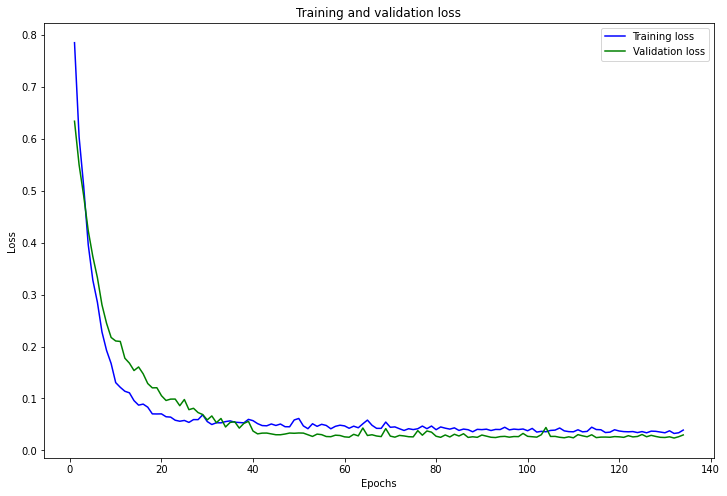

In [56]:
# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1) 

# plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss_values, 'blue',label='Training loss')
plt.plot(epochs, val_loss_values, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

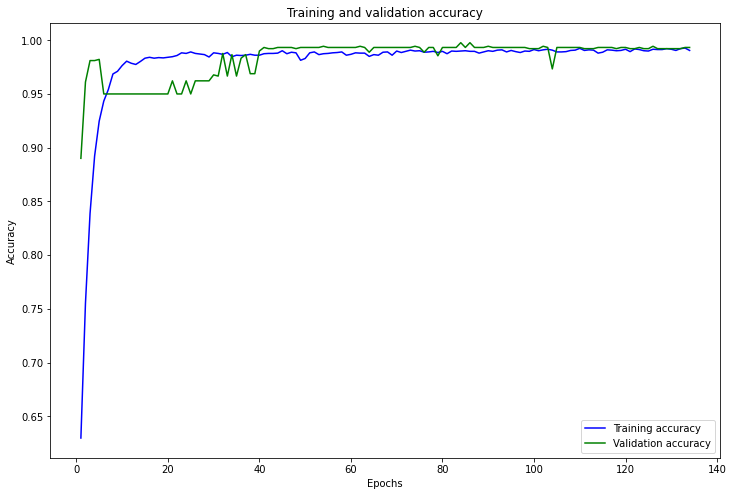

In [57]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, 'blue',label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'green', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **FURTHER EVALUATION METHODS**

In [59]:

results = model.evaluate(X_test, y_test, batch_size=250)
print("Test set accuracy = {} %".format( results[1]*100))

5/5 [==============================] - 0s 5ms/step - loss: 0.0666 - accuracy: 0.9911
Test set accuracy = 99.11268949508667 %


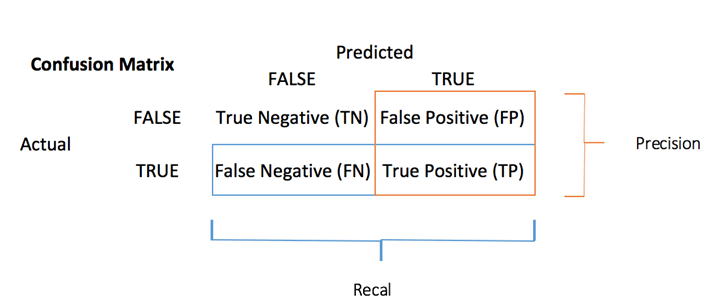

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

preds = np.round(model.predict(X_test),0)

#cm = confusion_matrix(y_test.values.argmax(axis=1), preds.argmax(axis=1))

cm = confusion_matrix(y_test, preds)

cm


array([[1044,    3],
       [   7,   73]])

In [61]:
preds.sum()   # predicted occurrencies of the to be classified traffic type


76.0

In [62]:
y_test.sum()

class1_b'VPN-VOIP'    80.0
dtype: float64